In [2]:
from helper import (load_data, token,time_me,
                    show_diagram, show_most_informative_features)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight') # plt.style.available

Loading data ...
Droping 10 rows with features lenght of less than 2
Droping 3 as rating and setting 1-2 as negative(0), 4-5 as positive(1))
{1: 460527, 0: 127232} 

Down sampling positive ratings to match negatives
Data loading completed
{1: 127232, 0: 127232} 

Execution Time: 4 seconds


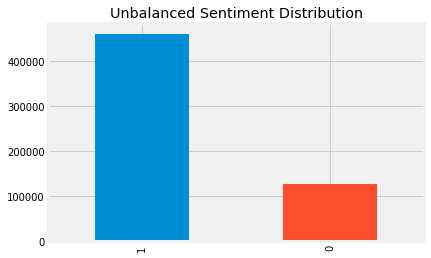

In [4]:
df = load_data('../sentiment_data')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
#Let start with a simple Pipeline that uses Multinomial Naive Bayes Classifier
#CountVectorizer will tokenize our sentences and build a dicitonary of features and transform doc to feature vectors
#Defualt is N-grams is one. We will deal with this later
#“Term Frequency times Inverse Document Frequency” tf–idf  divides the number of occurrences of each word in a document
# by the total number of words in the document

#tokenizer=tokenize made a lttle impact at all  0.88 to 0.89 Positive. It is slow, so not worth it

mnb_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),])

In [ ]:
#Lets train a model with Multinomial Naive Bayes Classifier
_ = mnb_clf.fit(X_train, y_train)

In [ ]:
#Curious Let check ...
simple_test = ['God og hurtig hjælp', 'Jeg fik en super god og hurtig behandling af min sag',
               'Det er mildest talt utrygt som potentiel kommende kunde, at jeres medarbejdere'+\
               ' ikke er i stand til at udfylde basale oplysninger på en police']
#The first two are positive while the last is negative. So we should have 1, 1, 0
mnb_clf.predict(simple_test)

In [ ]:
sent_text = ['jeg elsker mad','det er dårlig mad','det er ikke dårlig mad','det er ok','det er ikke ok','farvel']+simple_test

print('Problem with negatition is clear in 4nd and 5rd')
for i in mnb_clf.predict(sent_text):
    print([name for name,score in target_name.items() if score == i][0],':')
    print('\t', sent_text.pop(0))

In [ ]:
#What is our model score?
mnb_clf.score(X_test, y_test) #another way is: np.mean(mnb_clf.predict(X_test)==y_test)

In [ ]:
print(metrics.classification_report(y_test, mnb_clf.predict(X_test),target_names=['Negative','Positive']))

In [ ]:
#The best thing about Scikit-learn is inuitive easy design which allow you to change models without chaning much code
#change 'hinge' to 'los' to get predict_probaility
sgd_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)),])

In [ ]:
#How Good is Supported Vector Machine Classiffier
_ = sgd_clf.fit(X_train, y_train)
np.mean(sgd_clf.predict(X_test) == y_test)

In [ ]:
print(metrics.classification_report(y_test, sgd_clf.predict(X_test),target_names=['Negative','Positive']))

In [ ]:
sgd_clf2 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss ='log' ,penalty='l2',alpha=1e-3, n_iter=5, random_state=42)),]) #loss='hinge', 
_ = sgd_clf2.fit(X_train, y_train)
np.mean(sgd_clf2.predict(X_test) == y_test)

In [ ]:
#Using Grid Search CV(cross validation) we can find best vect ngram, tdidf_use and clf_alpha in SGD model
#n_jobs = -1 means using all cores power :)

parameters = {'vect__ngram_range': [(1,1),(1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),}
gsSGD_clf = GridSearchCV(sgd_clf, parameters, n_jobs=4)

In [ ]:
#This will take a while
_ = gsSGD_clf.fit(X_train, y_train)

In [ ]:
gsSGD_clf.best_estimator_

In [ ]:
gsSGD_clf.predict(['ikke'])

In [ ]:
print(metrics.classification_report(y_test, gsSGD_clf.predict(X_test),target_names=['Negative','Positive']))

In [ ]:
lr_clf  = Pipeline((
        ('vec',  CountVectorizer(ngram_range=(1, 2), max_features=100000)),
        ('fe_se', SelectKBest(chi2, k=5000)),
        ('clf', LogisticRegressionCV(n_jobs=4))
    ))

In [ ]:
#Takes a while to train :)
_= lr_clf.fit(X_train, y_train)

In [ ]:
lr_clf.score(X_test, y_test)

In [ ]:
print(metrics.classification_report(y_test, lr_clf.predict(X_test),target_names=['Negative','Positive']))

In [ ]:
#Function modification of Mike Lee Williams(mike@mike.place). All credit to Mike

feature_names = lr_clf.steps[0][1].get_feature_names()
feature_names = [feature_names[i] for i in 
                 lr_clf.steps[1][1].get_support(indices=True)]

def show_most_informative_features(feature_names, clf, n=1000):
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % ((coef_1), fn_1, (coef_2), fn_2))
